# DEM Download, Co-Registration, and Differencing for Geodetic Glacier Mass Balance Analysis 

### This Python workflow will walk you through the steps to: 

1. Pull the SRTM DEM corresponding to your study area from EarthAccess -OR- manually load an existing reference DEM of your choosing 
2. Load the additional DEM(s) you wish to co-register and the glacier polygons of your choosing (RGI, GLIMS, DGA, etc.)  
3. Reproject and resample DEMs to your chosen reference DEM (here SRTM, 30x30m resolution)
4. Perform DEM co-registration, following the workflow of Shean et al. (2023), an implementation of Nuth and Kääb (2011)
5. Clip the co-registered DEMs to glacier area 
6. Difference the DEMs to compute volume loss within glacier area 
7. Calculate geodetic glacier mass balance 
8. Produce figures  

This workflow has the following requirements: 
- a NASA EarthData login to download the SRTM elevation data. EarthData can be accessed at the following link: (https://urs.earthdata.nasa.gov/oauth/authorize?client_id=ZAQpxSrQNpk342OR77kisA&response_type=code&redirect_uri=https://appeears.earthdatacloud.nasa.gov/login&state=/)
- additional DEMs of the study area (e.g. UAV or satellite-derived product)

We use `earthaccess`, an open source package developed by Luis Lopez to download NASA data collections. It requires authentication using Earthdata Login credentials. See [https://github.com/nsidc/earthaccess](https://github.com/nsidc/earthaccess).

The workflow for Shean et al. (2023) DEM co-registration is found here: https://github.com/dshean/demcoreg

MS note to self: 
to activate virtual environment locally (in terminal): 


cd ~/Glacier-DEM-coregistration-and-MB

conda activate glacier-env

In [5]:
# Import required packages
import argparse
import os
import subprocess
import sys
import zipfile
import earthaccess
import folium
from folium.raster_layers import ImageOverlay
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pygeotools
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
import demcoreg
import rioxarray as rxr
import xarray as xr
import imview
import matplotlib.pyplot as plt

In [6]:
#Code to download SRTM DEM from EarthAccess

# Define output directory and bounding box
output_dir = "./srtm_data"
bounding_box = (-71.4, -36.8, -71.2, -36.6)  # Example bounding box for your study area

# Check if files already exist in the output directory
if not os.listdir(output_dir):  # If directory is empty
    # Enter your EarthAccess login and password 
    earthaccess.login()

    # Search for SRTM data
    query = earthaccess.search_datasets(
        keyword="SRTM",
    )

    results = earthaccess.search_data(
        short_name='SRTMGL1',  # SRTM 1-arcsecond Global dataset (confirm this is the right SRTM dataset...)
        cloud_hosted=True,  # Ensure access to cloud-stored data
        bounding_box=bounding_box
    )

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the files
    for granule in results:
        earthaccess.download(granule, output_dir)

    # Confirm download and print the results
    print(f"Downloaded {len(results)} SRTM DEM files to: {os.path.abspath(output_dir)}")
else:
    print(f"SRTM files already exist in {output_dir}, skipping download.")

# Print study area bounding box
print(f"Study area bounding box: {bounding_box}")



# Unzip the downloaded files if they exist
zip_files = [f for f in os.listdir(output_dir) if f.endswith(".zip")]
for zip_file in zip_files:
    zip_file_path = os.path.join(output_dir, zip_file)
    extracted_dir = output_dir  # Set the extraction directory to the same as output directory
    if not os.path.exists(os.path.join(extracted_dir, zip_file.replace(".zip", ""))):  # Check if file is already extracted
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        print(f"Unzipped file {zip_file} to: {extracted_dir}")
    else:
        print(f"File {zip_file} already unzipped.")

# Print study area bounding box
print(f"Study area bounding box: {bounding_box}")

SRTM files already exist in ./srtm_data, skipping download.
Study area bounding box: (-71.4, -36.8, -71.2, -36.6)
Unzipped file N58W134.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N59W134.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N58W135.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N59W135.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file S37W072.SRTMGL1.hgt.zip to: ./srtm_data
Study area bounding box: (-71.4, -36.8, -71.2, -36.6)


## Step 1: Pull SRTM for study area as reference DEM 

In [7]:
#Code to download SRTM DEM from EarthAccess

# Define output directory and bounding box
output_dir = "./srtm_data"
bounding_box = (-71.4, -36.8, -71.2, -36.6)  # Example bounding box for your study area

# Check if files already exist in the output directory
if not os.listdir(output_dir):  # If directory is empty
    # Enter your EarthAccess login and password 
    earthaccess.login()

    # Search for SRTM data
    query = earthaccess.search_datasets(
        keyword="SRTM",
    )

    results = earthaccess.search_data(
        short_name='SRTMGL1',  # SRTM 1-arcsecond Global dataset (confirm this is the right SRTM dataset...)
        cloud_hosted=True,  # Ensure access to cloud-stored data
        bounding_box=bounding_box
    )

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the files
    for granule in results:
        earthaccess.download(granule, output_dir)

    # Confirm download and print the results
    print(f"Downloaded {len(results)} SRTM DEM files to: {os.path.abspath(output_dir)}")
else:
    print(f"SRTM files already exist in {output_dir}, skipping download.")

# Print study area bounding box
print(f"Study area bounding box: {bounding_box}")



# Unzip the downloaded files if they exist
zip_files = [f for f in os.listdir(output_dir) if f.endswith(".zip")]
for zip_file in zip_files:
    zip_file_path = os.path.join(output_dir, zip_file)
    extracted_dir = output_dir  # Set the extraction directory to the same as output directory
    if not os.path.exists(os.path.join(extracted_dir, zip_file.replace(".zip", ""))):  # Check if file is already extracted
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        print(f"Unzipped file {zip_file} to: {extracted_dir}")
    else:
        print(f"File {zip_file} already unzipped.")

# Print study area bounding box
print(f"Study area bounding box: {bounding_box}")

SRTM files already exist in ./srtm_data, skipping download.
Study area bounding box: (-71.4, -36.8, -71.2, -36.6)
Unzipped file N58W134.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N59W134.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N58W135.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file N59W135.SRTMGL1.hgt.zip to: ./srtm_data
Unzipped file S37W072.SRTMGL1.hgt.zip to: ./srtm_data
Study area bounding box: (-71.4, -36.8, -71.2, -36.6)


## Visualize the DEM to confirm

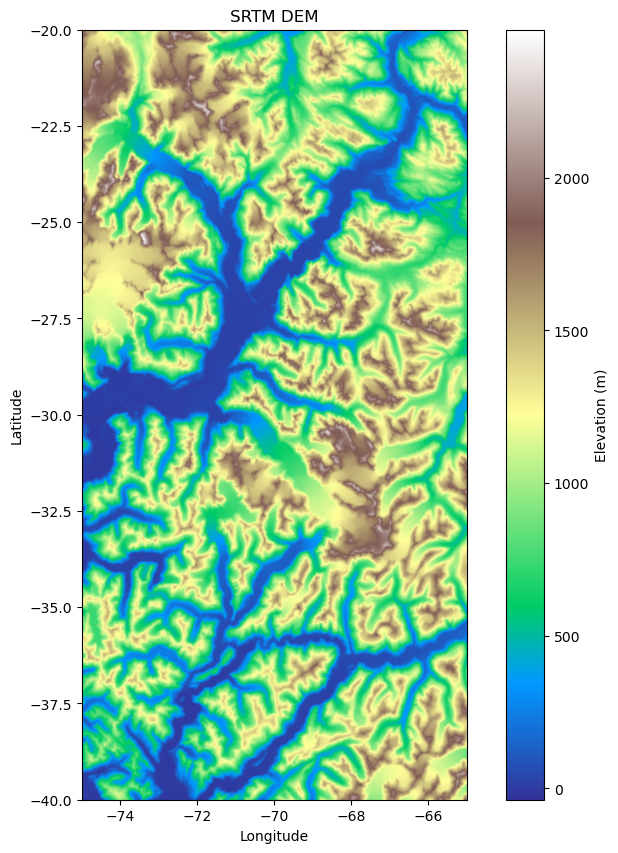

In [8]:
#Once the file is unzipped, read the .hgt file using rasterio:
# Define the path to the unzipped DEM file
dem_file = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/N58W134.hgt"

# Open the DEM file using rasterio
with rasterio.open(dem_file) as src:
    dem_data = src.read(1)  # Read the first band (DEM data)
    dem_transform = src.transform  # Get the spatial transform

# Plot the DEM using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(dem_data, cmap='terrain', extent=[-75, -65, -40, -20])  # Adjust the extent to cover Chile
plt.colorbar(label='Elevation (m)')
plt.title('SRTM DEM')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Step 2a: Load the glacier shapefiles and the additional DEMs you wish to work with 

Below is the code to unzip Chilean glacier inventory shapefiles (DGA,2000 or DGA,2019) OR use unzipped example shapefiles for Nevados de Chillán complex. If your study area is outside of Chile, you can download glacier polygons for your study area from GLIMS here: https://www.glims.org/maps/glims and manually upload below. 

In [14]:
# comment out code that doesn't apply depending on which glacier polygon source you choose

# # if using example DGA shapefiles (unzipped) for Nevados de Chillán (one for the year 2000 and one for 2019)
glacier_area_2000_path = "example_data_Nevados/Nevados_glacier_shapefiles/Nevados_shapefile_DGA2000/Nevados_polygons_DGA2000.shp"
glacier_area_2019_path = "example_data_Nevados/Nevados_glacier_shapefiles/Nevados_shapefile_DGA2019/Nevados_polygons_DGA2019.shp"

# Load the shapefiles
glacier_2000_gdf = gpd.read_file(glacier_area_2000_path)
glacier_2019_gdf = gpd.read_file(glacier_area_2019_path)

# Display the first few rows
print(glacier_2000_gdf.head())
print(glacier_2019_gdf.head())
print(type(glacier_area_2000_path))


   Id      COD_GLA NOMBRE             CLASIFICA  REGION    COMUNA   DATUM  \
0  10  CL108130010    S/N  GLACIAR DE MONTAï¿½A  BIOBIO     PINTO  WGS 84   
1   3  CL108100003    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
2   2  CL108100002    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
3   4  CL108100004    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
4   8  CL108130008    S/N            GLACIARETE  BIOBIO     PINTO  WGS 84   

    HUSO    ESTE    NORTE  ... ORIENABLAC ORIENTA CLAS_WGI  \
0  19SUR  288487  5915779  ...       None       S        6   
1  19SUR  288834  5916614  ...       None       N        7   
2  19SUR  289865  5916798  ...       None       E        7   
3  19SUR  288355  5916959  ...       None       E        7   
4  19SUR  287662  5916667  ...       None      SW        7   

             CLAS_2_CUB  ZONA_GLACI HMEDIANA PENDIENTE ERROR_KM2 ERROR_PORC  \
0  GLACIAR DE MONTAï¿½A    ZONA SUR   2907.0   26.7534  0.026888    19.3442   
1     

## Step 2b: Load the additional DEMs you wish to work with reproject to the same resolution and resample to the same grid

As an example, we provide an SRTM DEM, a DEM produced by 1954 Chilean military flights (IGM_1954), and two DEMs derived from uncrewed aerial vehicle (UAV) flights over Nevados de Chillán in March, 2024 (CerroBlanco and LasTermas). You can manually upload your DEMs to the same folder or route to a local file on your computer. Alternatively, you can modify the code in Step 1 to pull other DEM products from online platforms (e.g. IceSAT/-2, ArcticDEM, etc.). 

We also provide the GLIMS polygons in raster format ... 

In [4]:
# Path to your data folder
DEM_folder = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/example_data_Nevados/Nevados_DEMs"

# List of DEM filenames
dem_files = [
    "CerroBlanco_2024.tif",
    "LasTermas_2024.tif",
    "SRTM_2000.tif",
    "IGM_1954.tif"
]  

# Dictionary to hold opened DEM datasets
dem_datasets = {}

# Load all DEMs into a dictionary
for dem_file in dem_files:
    file_path = os.path.join(DEM_folder, dem_file)
    dem_name = os.path.splitext(dem_file)[0]  # Remove .tif extension
    dem_datasets[dem_name] = rasterio.open(file_path)
    # Optional: print CRS and resolution of each DEM to confirm they’re loaded
    print(f"{dem_name}: CRS = {dem_datasets[dem_name].crs}, Resolution = {dem_datasets[dem_name].res}")

# Open DEMs into xarray
dems = {name: rxr.open_rasterio(path, masked=True).squeeze() for name, path in dem_datasets.items()}

# Define target CRS (EPSG for UTM Zone 19 South, WGS 84 / UTM 19S)
target_crs = "EPSG:32719"

# Reproject all DEMs to the target CRS
for name in dems:
    dems[name] = dems[name].rio.reproject(target_crs)

# Reference DEM for resampling (SRTM_2000)
reference = dems['SRTM_2000']

# Function to match resolution and grid (snapping) to reference DEM
def resample_and_align_to_reference(dem_datasets, reference):
    return dem_datasets.rio.reproject_match(reference, resampling=Resampling.bilinear)

# Resample all DEMs to match SRTM_2000 resolution and grid alignment
for name in dems:
    if name != 'SRTM_2000':  # Skip the reference DEM
        dems[name] = resample_and_align_to_reference(dems[name], reference)

# Define output folder for aligned DEMs
output_folder = "aligned_dems"
os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

# Print CRS and spatial resolution of aligned DEMs to confirm reprojection and alignment
for name, dem_dataset in dems.items():
    res = dem_dataset.rio.resolution()
    print(f"{name} CRS: {dem_dataset.rio.crs}, Resolution: {abs(res[0]):.2f} x {abs(res[1]):.2f} meters")


# Save the aligned DEMs to the output folder
for name, dem_datasets in dems.items():
    dem_datasets.rio.to_raster(os.path.join(output_folder, f"{name}_aligned.tif"))
print(f"All DEMs successfully aligned and saved to {output_folder}")


CerroBlanco_2024: CRS = EPSG:4326, Resolution = (8.761960000002116e-07, 7.042859999999532e-07)
LasTermas_2024: CRS = EPSG:4326, Resolution = (1.8726799999998898e-06, 1.504369999999964e-06)


RasterioIOError: '/Users/milliespencer/Glacier-DEM-coregistration-and-MB/example_data_Nevados/Nevados_DEMs/SRTM_2000.tif' not recognized as being in a supported file format.

In [3]:
print(type(aligned_dems/CerroBlanco_2024_aligned.tif))

NameError: name 'aligned_dems' is not defined

## Step 3: DEM co-registration 
Here we follow the workflow provided by Shean et al. (2023), derived from the Nuth and Kääb (2011) method, here: https://github.com/dshean/demcoreg/blob/master/docs/beginners_doc.md

The code below references Shean's 'dem_align.py - robust raster DEM co-registration' script, which housed here in the coreg_directory

### Perform co-registration: 
Loading the DEMs, reprojecting the DEMs to the same spatial reference system, and calculating slope and aspect to use in the co-registration process. 

* if you're jumping in at this step, and your DEMs aren't in the same projection, use this command in your terminal to reproject a DEM: < gdalwarp -r cubic -t_srs EPSG:XXXXX > (XXXXX = projection of your choosing)
* then run: < dem_align.py -mode nuth dem1.tif dem2.tif > to co-register your DEMs. Here, dem2 (source) is co-registered to dem1 (reference). 
* the code will output your coregistered dem2, as well as summary statistics and additional files. For our purposes, the file name ending with *_align.tif is the outputted co-registered DEM we're interested in using. 